In [1]:
import matplotlib
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import pandas as pd
import scipy.fftpack
import gc
import patched_gpr
import sklearn.gaussian_process as gp
import importlib
from Todd_eeg_utils import *
np.random.seed(1)




logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [2]:
signal_subsample_rate = 5
SIGNAL_HZ = 250
HZ=int(SIGNAL_HZ/signal_subsample_rate)
EEG_CHANNELS=21
SECONDS_OF_SIGNAL=100
l = HZ*SECONDS_OF_SIGNAL
gpr_subsample_rate=10
bandwidth = 2*HZ
n = 2*bandwidth-1

RUN=19
WHICH_DATA_FILE=6
# training sets so far are the 5th file (run 9), the 23rd file (run 10)
# run 11(5th w white noise) run 12(6th w single rbf) run 13(5th w single rbf)
#run 13 (5 single rbf thetawaves)
#run 14 (5 single rbf deltawaves)
#run 15 (6 single rbf deltawaves)
#----- fixed the weighting scheme
#run 17 (5 3 rbf repaired weighting)
#run 18 (5 single rbf thetawaves)
#run 19 (6 single rbf thetawaves)

In [58]:
WHICH_DATA_FILE

6

In [3]:
mpl.rcParams['figure.figsize'] = [16.0*SECONDS_OF_SIGNAL/20, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*4)

In [4]:
def adjust_ax_labels(axs, rng, n_ticks=8, hz=250):
    try:
        axs_iterator = iter(axs)
    except TypeError as te:
        axs_iterator = iter([axs])
    for ax in axs_iterator:
        ax.axis("off")
    ax.axis("on")
    x_ticks = np.linspace(rng[0],rng[1],n_ticks)
    x_tick_labels = x_ticks/hz
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(list(map(lambda x: "{:.01f}".format(x), x_tick_labels)))
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)        

In [5]:
#HB suggests using std(X)*n**(-1/5)... since std(X) depends crucially on the length of the signal, how can this help?

In [6]:
project_dir = "/home/brown/disk2/eeg/todd_eeg_gpr_fixed_rbfs_run{:03d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

In [7]:
data_dir = "/home/brown/disk2/eeg/Phasespace/Phasespace/data/eeg-text"

In [8]:
data_info = pd.read_csv(os.path.join(data_dir, "fileinformation.csv"), skiprows=1).iloc[:,2:]

In [9]:
data_info

,Unnamed: 2,Number of Records,Time of Seizure,Unnamed: 5,Point of Seizure,250
0,DAT.F00012,3963799,14040,NaN,3510000,3510000
1,DAT.F00013,3632699,12720,NaN,3180000,3180000
2,DAT.F00016,4447824,15960,NaN,3990000,3990000
3,DAT.F00017,1827224,0,NaN,0,0
4,DAT.F00018,2985924,10020,NaN,2505000,2505000
5,DAT.F00019,3692374,12960,NaN,3240000,3240000
6,DAT.F00020,3270974,11280,NaN,2820000,2820000
7,DAT.F00022,2120524,0,NaN,0,0
8,DAT.F00024,3378499,11700,NaN,2925000,2925000
9,DAT.F00026,3370999,0,NaN,0,0


In [10]:
data_file = data_info.iloc[WHICH_DATA_FILE,0]

In [11]:
dat = np.loadtxt(os.path.join(data_dir, data_file))

In [12]:
dat.shape[0]

3270974

In [13]:
best_fft_len = previous_best_fft_len(dat.shape[0])
best_fft_len

3240000

In [14]:
dat.shape

(3270974, 32)

In [15]:

data_offset

30974

557805.2

In [17]:
dat = dat[data_offset:]

In [18]:
#a computationally convenient approximation to the beta... sig on [0,1]
def kumaraswamy(sig,a=1.,b=1.):
    return a*b*sig**(a-1)*(1-sig**a)**(b-1)
def spectrum(sig, d):
    f = scipy.fftpack.rfftfreq(sig.size, d=d)
    y = scipy.fftpack.rfft(sig)
    return f, y
def kumaraswamy_filter(sig,d,a=1.,b=1.):
    f, y = spectrum(sig, d)
    max_f = np.max(f)
    kumaraswamy_filter = kumaraswamy(f/max_f,a,b)
    kumaraswamy_filter /= np.max(kumaraswamy_filter) #scale units
    y *= kumaraswamy_filter
    filtered_sig = scipy.fftpack.irfft(y)
    return filtered_sig

In [19]:
a = 1.2; b=10.
filtered_data_dir = os.path.join(data_dir, "filtered_data")
os.makedirs(filtered_data_dir, exist_ok=1)
filtered_data_filename = os.path.join(filtered_data_dir, "kumaraswamy_filtered_data_eeg{}_a{:05.02f}_b{:05.02f}".format(data_file, a, b))

In [20]:
f, y = spectrum(dat[:,0], 1/SIGNAL_HZ)

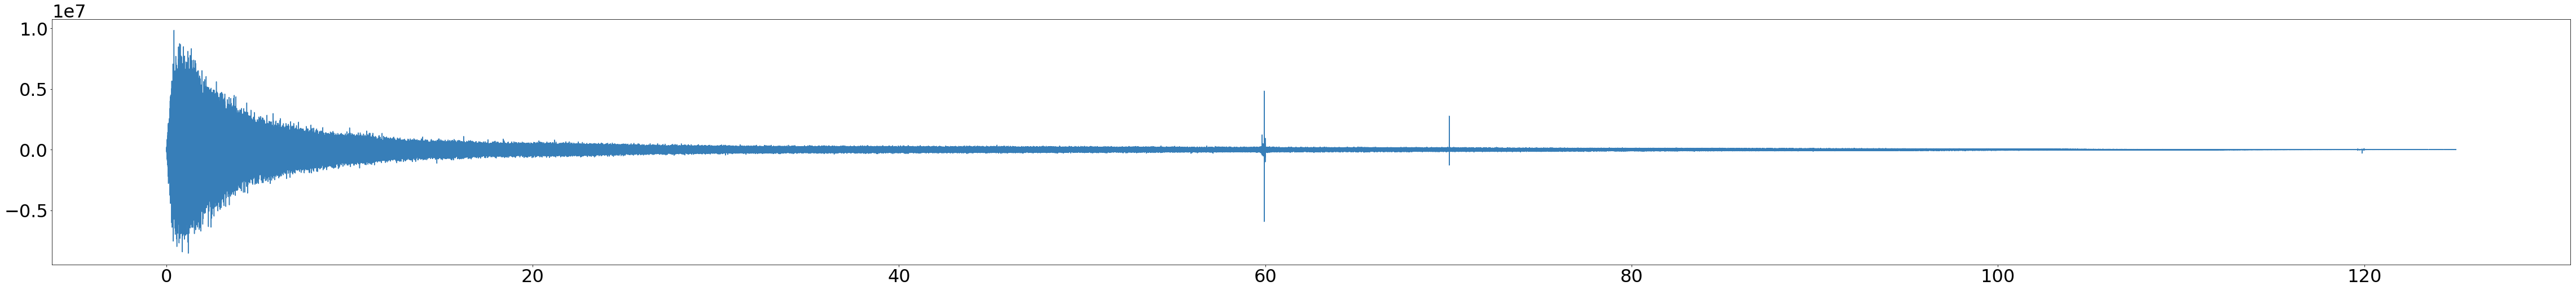

In [21]:
plt.plot(f,y)

In [77]:
os.path.isfile(filtered_data_filename)

True

In [78]:
if not os.path.isfile(filtered_data_filename):
    filtered_dat = np.empty(dat[:,:EEG_CHANNELS].shape)
    for channel in range(EEG_CHANNELS):
        print(channel)
        filtered_dat[:,channel] = kumaraswamy_filter(dat[:,channel],1/SIGNAL_HZ,a,b)
    np.savetxt(filtered_data_filename, filtered_dat)
else:
    filtered_dat, data_offset = get_filtered_data(data_file, data_dir)

In [79]:
filtered_dat.shape

(3270974, 21)

In [80]:
data_offset

0

In [81]:
dat.shape[0] - filtered_dat.shape[0]

-30974

In [82]:
data_offset = dat.shape[0] - best_fft_len

In [83]:
subsampled_dat = filtered_dat[::signal_subsample_rate]

In [84]:
data_epipoint = int((data_info.iloc[WHICH_DATA_FILE,4]-data_offset)/signal_subsample_rate)

In [85]:
ictal_rng = (max(0,data_epipoint-l), min(subsampled_dat.shape[0], data_epipoint+l))
negative_ictal_rng = (max(0, int(data_epipoint/2)-l), min(subsampled_dat.shape[0], int(data_epipoint/2)+l))
subsample_ictal_rng = (np.array(ictal_rng)/gpr_subsample_rate).astype(int)
subsample_negative_ictal_rng = (np.array(negative_ictal_rng)/gpr_subsample_rate).astype(int)
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
index_X = np.arange(subsampled_dat.shape[0]*1.).reshape(-1,1)
index = local_models.local_models.ConstantDistanceSortedIndex(index_X.flatten())
exemplar_rng = (HZ*4,HZ*4+n) 
exemplar_X = index_X[slice(*exemplar_rng)]
ictal_X = index_X[slice(*ictal_rng)]
ictal_X_gpr_subsampled = index_X[ictal_rng[0] : ictal_rng[1] : gpr_subsample_rate]
exemplar_X_gpr_subsampled = index_X[exemplar_rng[0] : exemplar_rng[1] : gpr_subsample_rate]
negative_ictal_X = index_X[slice(*negative_ictal_rng)]
negative_ictal_X_gpr_subsampled = index_X[negative_ictal_rng[0] : negative_ictal_rng[1] : gpr_subsample_rate]

In [26]:
class GPR(patched_gpr.GaussianProcessRegressor):
    def fit(self, X,y,sample_weight=None, **kwargs):
        if "beta0" in kwargs:
            self.kernel.theta = kwargs["beta0"]
            del kwargs["beta0"]
        the_model = super().fit(X,y,sample_weight, **kwargs)
        self.coef_ = the_model.kernel_.theta
        self.intercept_ = np.empty((0,))
        return the_model

## Find the rbf lengthscales for various size waves

In [27]:
X = np.arange(n)
MEAN_BETAWAVE_PERIOD = 19
MEAN_ALPHAWAVE_PERIOD = 11
MEAN_THETAWAVE_PERIOD = 5.5
MEAN_DELTAWAVE_PERIOD = 2
sample_betawaves = 250*np.sin(2*np.pi*MEAN_BETAWAVE_PERIOD/HZ*X)
sample_alphawaves = 250*np.sin(2*np.pi*MEAN_ALPHAWAVE_PERIOD/HZ*X)
sample_thetawaves = 250*np.sin(2*np.pi*MEAN_THETAWAVE_PERIOD/HZ*X)
sample_deltawaves = 250*np.sin(2*np.pi*MEAN_DELTAWAVE_PERIOD/HZ*X)

In [28]:
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
lm_kernel(X-n/2)

array([2.87320724e-06, 7.52763330e-05, 3.38134141e-04, 9.00148264e-04,
       1.85585911e-03, 3.28662186e-03, 5.26153744e-03, 7.83833969e-03,
       1.10642404e-02, 1.49767336e-02, 1.96043598e-02, 2.49674328e-02,
       3.10787292e-02, 3.79441422e-02, 4.55633015e-02, 5.39301591e-02,
       6.30335447e-02, 7.28576884e-02, 8.33827154e-02, 9.45851111e-02,
       1.06438159e-01, 1.18912352e-01, 1.31975780e-01, 1.45594488e-01,
       1.59732819e-01, 1.74353726e-01, 1.89419068e-01, 2.04889885e-01,
       2.20726648e-01, 2.36889497e-01, 2.53338457e-01, 2.70033638e-01,
       2.86935419e-01, 3.04004612e-01, 3.21202620e-01, 3.38491572e-01,
       3.55834446e-01, 3.73195186e-01, 3.90538799e-01, 4.07831443e-01,
       4.25040506e-01, 4.42134672e-01, 4.59083978e-01, 4.75859865e-01,
       4.92435215e-01, 5.08784382e-01, 5.24883221e-01, 5.40709098e-01,
       5.56240906e-01, 5.71459067e-01, 5.86345532e-01, 6.00883769e-01,
       6.15058761e-01, 6.28856979e-01, 6.42266373e-01, 6.55276337e-01,
      

In [29]:
simple_kernel = np.sum((
    np.prod((
        gp.kernels.ConstantKernel(constant_value=10e5, constant_value_bounds=[0.001,1e10]),
        gp.kernels.RBF(length_scale=HZ/10, length_scale_bounds=[1e-5,1e5])
    )),
    gp.kernels.WhiteKernel(noise_level=1e-9, noise_level_bounds=[1e-9,1e-9])
))

In [30]:
np.random.seed(0)

In [31]:
simple_regressor = GPR(kernel=simple_kernel, normalize_y=True, n_restarts_optimizer=400,alpha=0)
simple_regressor.fit(X.reshape(-1,1), sample_betawaves, sample_weight=lm_kernel(X-n/2))

GPR(alpha=0, copy_X_train=True,
    kernel=1e+03**2 * RBF(length_scale=5) + WhiteKernel(noise_level=1e-09),
    n_restarts_optimizer=400, normalize_y=True, optimizer='fmin_l_bfgs_b',
    random_state=None)

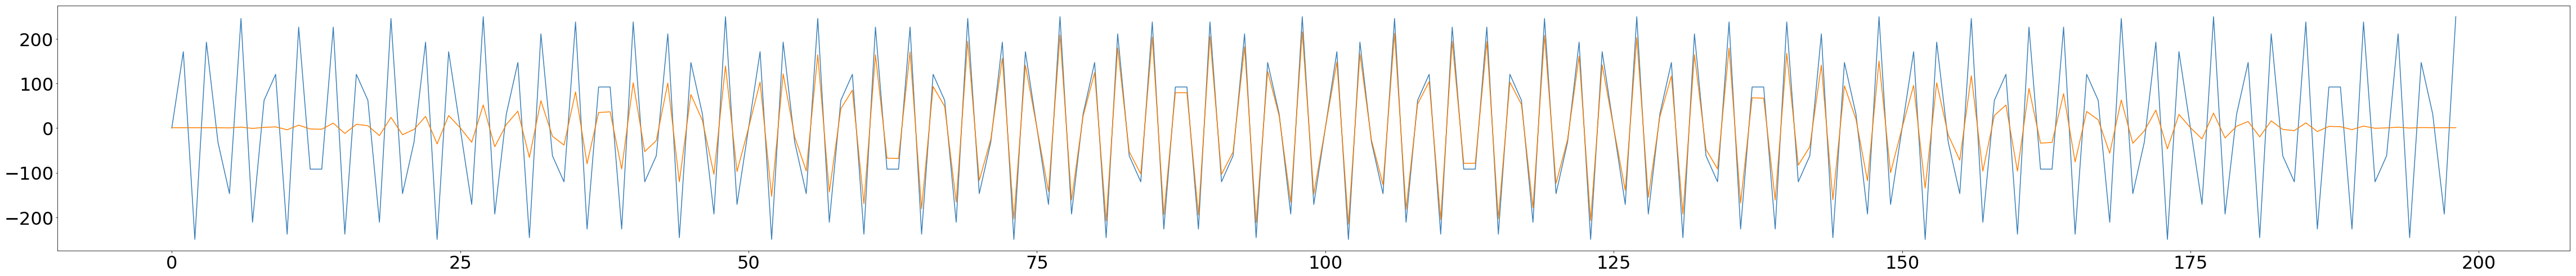

In [32]:
plt.plot(X,sample_betawaves)
plt.plot(X,simple_regressor.predict(X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "betawaves.png"))

In [33]:
betawave_c, betawave_lengthscale = np.exp(simple_regressor.kernel_.theta[:2])
betawave_c, betawave_lengthscale

(15703.883337003092, 4.380008602624772e-05)

In [34]:
simple_regressor = GPR(kernel=simple_kernel, normalize_y=True, n_restarts_optimizer=400,alpha=0)
simple_regressor.fit(X.reshape(-1,1), sample_alphawaves, sample_weight=lm_kernel(X-n/2))

GPR(alpha=0, copy_X_train=True,
    kernel=1e+03**2 * RBF(length_scale=5) + WhiteKernel(noise_level=1e-09),
    n_restarts_optimizer=400, normalize_y=True, optimizer='fmin_l_bfgs_b',
    random_state=None)

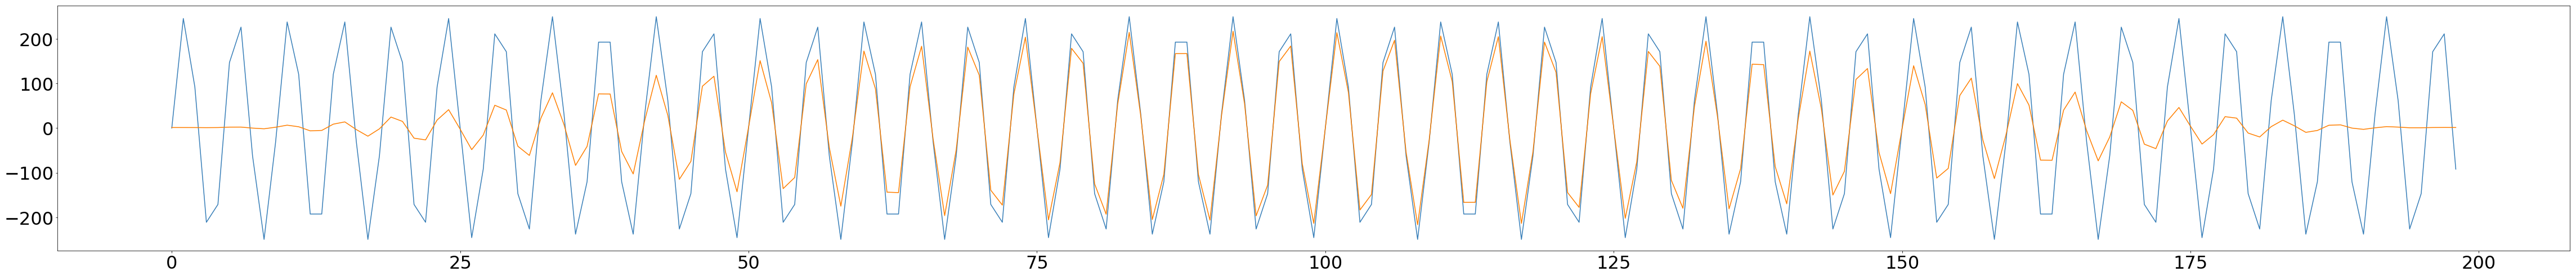

In [35]:
plt.plot(X, sample_alphawaves)
plt.plot(X,simple_regressor.predict(X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "alphawaves.png"))

In [36]:
alphawave_c, alphawave_lengthscale = np.exp(simple_regressor.kernel_.theta[:2])
alphawave_c, alphawave_lengthscale

(15147.521262978276, 0.8812271580094064)

In [37]:
simple_regressor = GPR(kernel=simple_kernel, normalize_y=True, n_restarts_optimizer=400,alpha=0)
simple_regressor.fit(X.reshape(-1,1), sample_thetawaves, sample_weight=lm_kernel(X-n/2))

GPR(alpha=0, copy_X_train=True,
    kernel=1e+03**2 * RBF(length_scale=5) + WhiteKernel(noise_level=1e-09),
    n_restarts_optimizer=400, normalize_y=True, optimizer='fmin_l_bfgs_b',
    random_state=None)

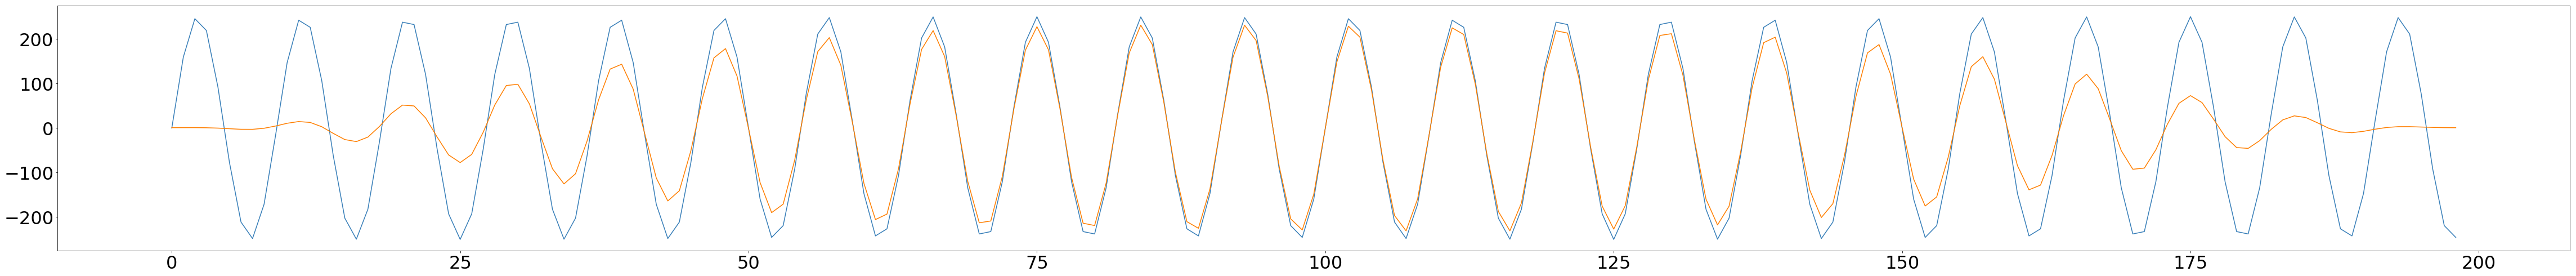

In [38]:
plt.plot(X,sample_thetawaves)
plt.plot(X,simple_regressor.predict(X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "thetawaves.png"))

In [39]:
thetawave_c, thetawave_lengthscale = np.exp(simple_regressor.kernel_.theta[:2])
thetawave_c, thetawave_lengthscale

(8896.703909601687, 1.714352550416351)

In [40]:
simple_regressor = GPR(kernel=simple_kernel, normalize_y=True, n_restarts_optimizer=400,alpha=0)
simple_regressor.fit(X.reshape(-1,1), sample_deltawaves, sample_weight=lm_kernel(X-n/2))

GPR(alpha=0, copy_X_train=True,
    kernel=1e+03**2 * RBF(length_scale=5) + WhiteKernel(noise_level=1e-09),
    n_restarts_optimizer=400, normalize_y=True, optimizer='fmin_l_bfgs_b',
    random_state=None)

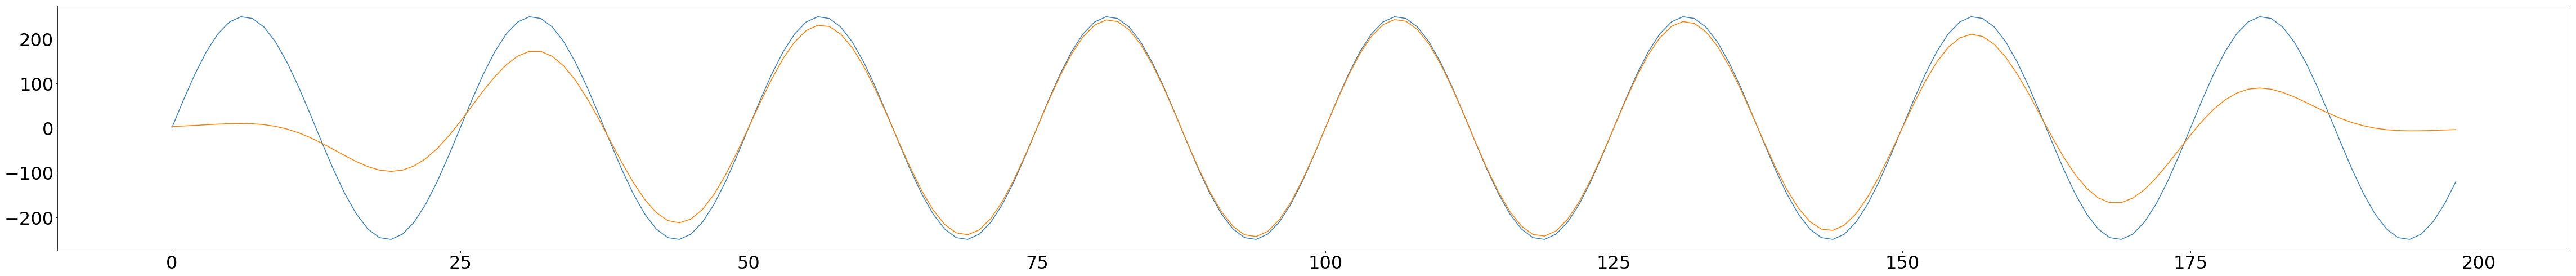

In [41]:
plt.plot(X,sample_deltawaves)
plt.plot(X,simple_regressor.predict(X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "deltawaves.png"))

In [42]:
deltawave_c, deltawave_lengthscale = np.exp(simple_regressor.kernel_.theta[:2])
deltawave_c, deltawave_lengthscale

(3781.910466187349, 4.430353258917105)

## Fit exemplar GPR to get starting values

In [43]:
kernel = np.sum((
    #np.prod((#delta waves
    #    gp.kernels.ConstantKernel(constant_value=deltawave_c, constant_value_bounds=[0.001,1e10]),
    #    gp.kernels.RBF(length_scale=deltawave_lengthscale, length_scale_bounds="fixed")
    #)),
    np.prod((#theta waves
        gp.kernels.ConstantKernel(constant_value=thetawave_c, constant_value_bounds=[0.001,1e10]),
        gp.kernels.RBF(length_scale=thetawave_lengthscale, length_scale_bounds="fixed")
    )),
    #np.prod((#alpha waves
    #    gp.kernels.ConstantKernel(constant_value=alphawave_c, constant_value_bounds=[0.001,1e10]),
    #    gp.kernels.RBF(length_scale=alphawave_lengthscale, length_scale_bounds="fixed")
    #)),
    #np.prod((#beta waves
    #    gp.kernels.ConstantKernel(constant_value=betawave_c, constant_value_bounds=[0.001,1e10]),
    #    gp.kernels.RBF(length_scale=betawave_lengthscale, length_scale_bounds="fixed")
    #)),
    gp.kernels.WhiteKernel(noise_level=1, noise_level_bounds="fixed")
))

In [44]:
f,y = spectrum(subsampled_dat[:,0],1/HZ)

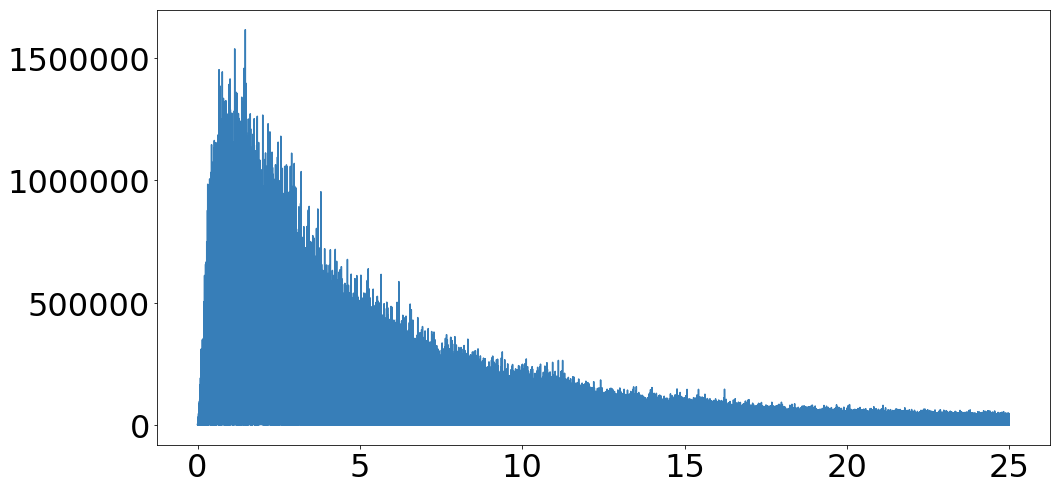

In [45]:
fig = plt.figure(figsize=(16,8))
plt.plot(f,np.abs(y))

In [46]:
f,y = spectrum(filtered_dat[:,0],1/SIGNAL_HZ)

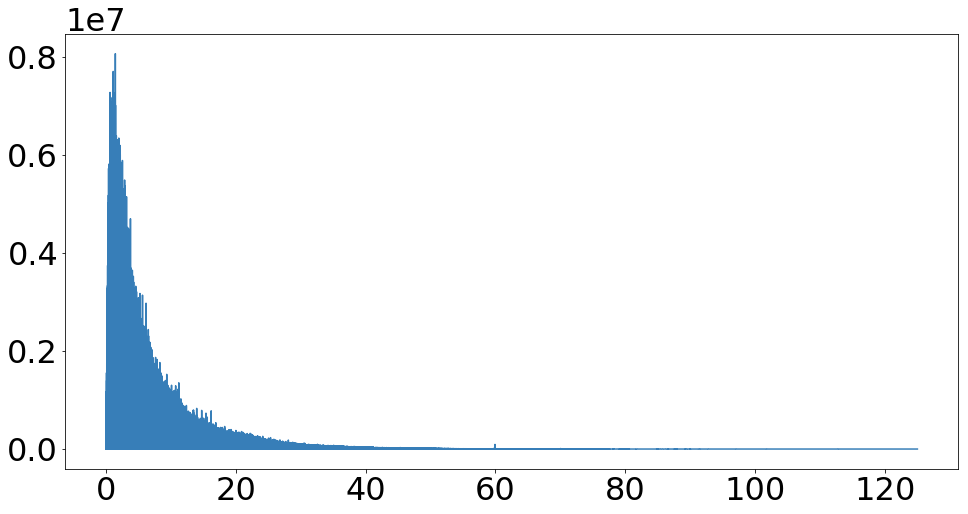

In [47]:
fig = plt.figure(figsize=(16,8))
plt.plot(f,np.abs(y))

In [48]:
filtered_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)

In [49]:
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

In [50]:
filtered_exemplar_gpr = filtered_regressor.fit(
    exemplar_X.reshape(-1,1), subsampled_dat[slice(*exemplar_rng),0],
    lm_kernel(np.abs(exemplar_X-np.mean(exemplar_X)))[:,0])

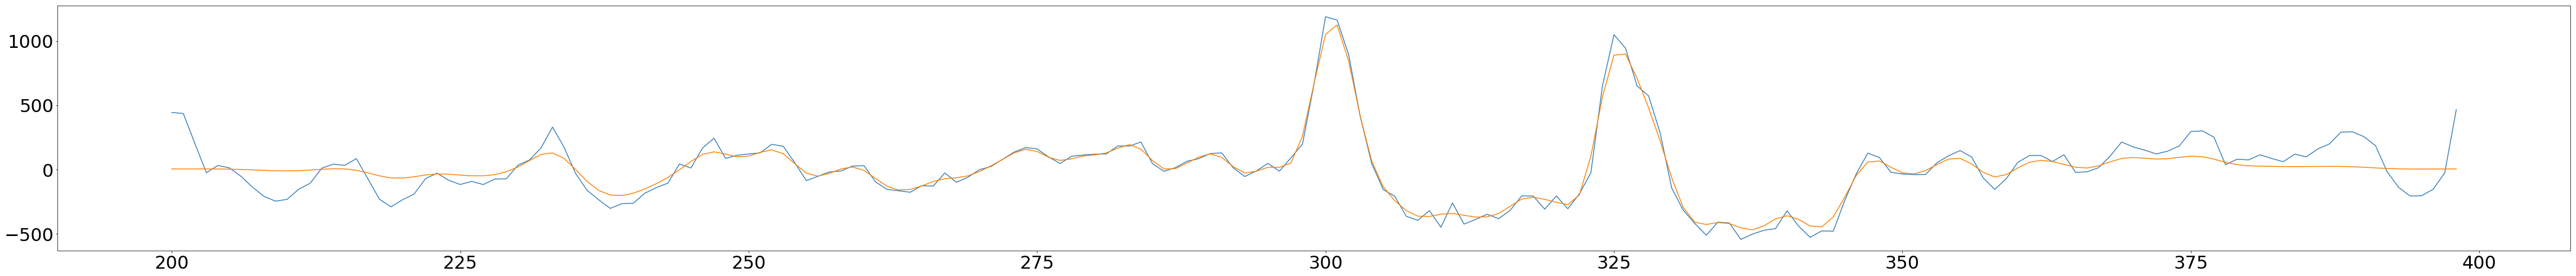

In [51]:
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
#adjust_ax_labels(axs,rng,hz=HZ)
axs.plot(exemplar_X, subsampled_dat[slice(*exemplar_rng),0])
axs.plot(exemplar_X, filtered_exemplar_gpr.predict(exemplar_X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "filtered_exemplar_gpr_rng{}.png".format(str(exemplar_rng))))

In [52]:
np.exp(filtered_exemplar_gpr.kernel_.theta)

array([24386.55541079])

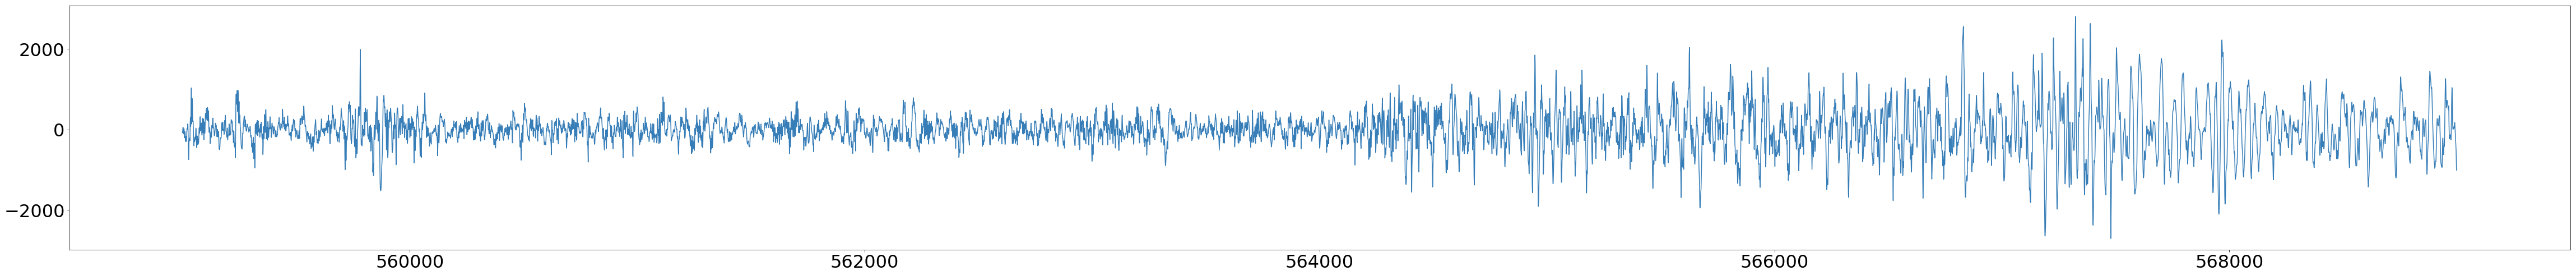

In [86]:
plt.plot(ictal_X, subsampled_dat[slice(*ictal_rng),0])

In [87]:
filtered_local_regressor = GPR(kernel=filtered_exemplar_gpr.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
y = subsampled_dat[:,0]
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
filtered_gpr_models = local_models.local_models.LocalModels(filtered_local_regressor)
filtered_gpr_models.fit(index_X,y,index=index)

In [88]:
filtered_gpr_params = filtered_gpr_models.transform(ictal_X_gpr_subsampled,r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int((subsample_ictal_rng[1] - subsample_ictal_rng[0])/10))

In [89]:
def clear(fig, axs):
    for ax in axs:
        ax.clear()
    fig.clear()
    plt.close(fig)
    plt.close("all")

In [90]:
def plt_gpr_params(X, y, gpr_X, gpr_params, chg_ptses, kernel, filename, hz=HZ, display=False, legend=True):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    adjust_ax_labels(axs,(np.min(X), np.max(X)),hz=HZ)
    artists = []
    extra_dims = []
    colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for var in range(gpr_params.shape[1]):
        c = next(colors)
        ar = axs[0].plot(gpr_X, gpr_params[:,var],c=c)
        artists.append(ar[0])
    for i, chg_pts in enumerate(chg_ptses):
        if i==0:
            extra_dims.append("true change points")
        elif i==1:
            extra_dims.append("pred change points")
        c = next(colors)
        for chg_pt in chg_pts:
            for ax in axs:
                ar = ax.axvline(chg_pt,c=c,lw=2,linestyle=(i*5,(5,5)))
        artists.append(ar)
    c = next(colors)
    ar = axs[1].plot(X, y, c=c)
    extra_dims.append("raw data")
    artists.append(ar[0])
    if legend:
        axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])) + extra_dims,loc="lower left")
    if filename:
        plt.savefig(filename)
    if not display:
        clear(fig, axs)

In [91]:
data_epipoint/HZ

11280.0

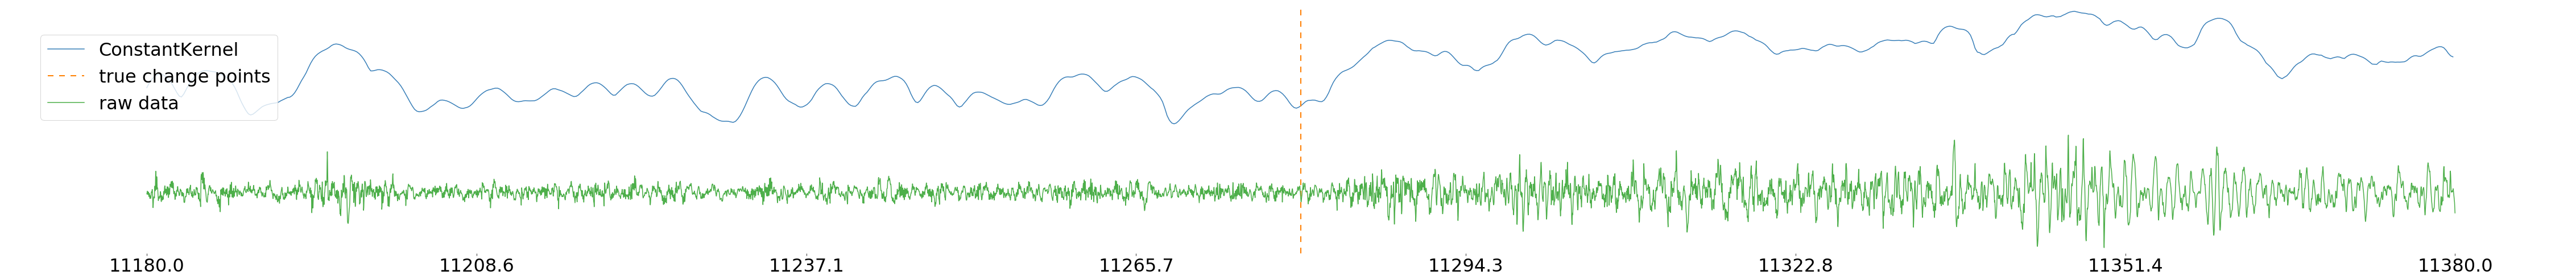

In [92]:
filename = os.path.join(project_dir, "filtered_gpr_params_subsamplerate{:07d}_kernel{}.png".format(gpr_subsample_rate, str(lm_kernel)))
plt_gpr_params(
    ictal_X, subsampled_dat[slice(*ictal_rng),0],
    ictal_X_gpr_subsampled, filtered_gpr_params,
    [[data_epipoint]],
    kernel, filename, display=True)

## Transform all of the channels

In [ ]:
exemplar_gprs = []
timelog = local_models.local_models.loggin.TimeLogger(
    logger=logger, 
    how_often=1, total=EEG_CHANNELS, 
    tag="training exemplar_gprs{}".format(data_file))

for channel in range(EEG_CHANNELS):
    with timelog:
        filtered_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)
        filtered_exemplar_gpr = filtered_regressor.fit(
            exemplar_X.reshape(-1,1), 
            subsampled_dat[slice(*exemplar_rng),channel], 
            lm_kernel(np.abs(exemplar_X[:,0]-np.mean(exemplar_X[:,0]))))
        exemplar_gprs.append(filtered_exemplar_gpr)

In [ ]:
transformed_data_dir = os.path.join(project_dir, "transformed_data_fixed_rbf_{:03d}".format(RUN))
os.makedirs(transformed_data_dir, exist_ok=1)

In [ ]:
timelog = local_models.local_models.loggin.TimeLogger(
    logger=logger, 
    how_often=1, total=EEG_CHANNELS, 
    tag="local gpr eeg transform eeg{}".format(data_file))

for channel in range(EEG_CHANNELS):
    with timelog:
        transformed_data_filename = os.path.join(transformed_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(ictal_rng), channel))
        #fit an exemplar gpr to get optimizer starting parameters
        filtered_exemplar_gpr = exemplar_gprs[channel]
        #fit the local models
        filtered_local_regressor = GPR(kernel=filtered_exemplar_gpr.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        y = subsampled_dat[:,channel]
        filtered_gpr_models = local_models.local_models.LocalModels(filtered_local_regressor)
        filtered_gpr_models.fit(index_X,y,index=index)
        filtered_gpr_params = filtered_gpr_models.transform(index_X[ictal_rng[0]:ictal_rng[1]:gpr_subsample_rate,:],r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int((subsample_ictal_rng[1] - subsample_ictal_rng[0])/10))
        np.savetxt(transformed_data_filename, filtered_gpr_params)

In [ ]:
transformed_data_img_dir = os.path.join(transformed_data_dir, "transformed_data_imgs")
os.makedirs(transformed_data_img_dir, exist_ok=1)

In [ ]:
for channel in range(EEG_CHANNELS):
    print(channel)
    transformed_data_filename = os.path.join(transformed_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(ictal_rng), channel))
    transformed_data_img_filename = os.path.join(transformed_data_img_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.png".format(str(lm_kernel), str(ictal_rng), channel))
    y = subsampled_dat[slice(*ictal_rng),channel]
    gpr_params = np.loadtxt(transformed_data_filename)
    plt_gpr_params(ictal_X, y, ictal_X_gpr_subsampled, gpr_params, data_epipoint, kernel, transformed_data_img_filename)

In [ ]:
import importlib; importlib.reload(local_models.algorithms)
importlib.reload(local_models.TLS_models)

In [ ]:
def fit_meanshift(gpr_paramses, kernel):
    mean_regressor = local_models.TLS_models.LinearODR_mD(0)
    mean_models = local_models.local_models.LocalModels(mean_regressor)
    mean_models.fit(gpr_paramses)
    for i, (dat, report) in enumerate(local_models.algorithms.local_tls_shift_till_convergence(
                mean_models, gpr_paramses, kernel=kernel, report=True)):
        if not i%100:
            #print(report)
            pass
    return dat
    
def cleanup_meanshift(meanshifted_data, tol=1e-7): 
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(meanshifted_data)
    bins = bt.query_radius(meanshifted_data, r=tol)
    cleanuped = np.empty(meanshifted_data.shape)
    for i, the_bin in enumerate(bins):
        cleanuped[i] = np.mean(meanshifted_data[the_bin], axis=0)
    return cleanuped
    
def pick_optimal_meanshift_bandwidth(initial_bandwidths, gpr_paramses, iterations=7):
    #go middle of the road to get two clusters.
    #i.e. find the minimum bandwidth giving 3, the max giving 1, then take their average
    print(iterations)
    checked_bandwidths = []
    given_n_clusters = []
    if iterations == 0:
        return checked_bandwidths, given_n_clusters
    for bandwidth in initial_bandwidths:
        ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
        fitted_meanshift = fit_meanshift(gpr_paramses, ms_kernel)
        fitted_meanshift = cleanup_meanshift(fitted_meanshift)
        observed_clusters = np.unique(fitted_meanshift, axis=0).shape[0]
        checked_bandwidths.append(bandwidth)
        given_n_clusters.append(observed_clusters)
    #get half of the ones, and half of the twos:
    the_ones = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==1]
    the_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==2]
    the_more_than_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]>2]
    median_the_ones = np.median(the_ones) if the_ones else max(initial_bandwidths)*2
    median_the_more_than_twos = np.median(the_more_than_twos) if the_more_than_twos else min(initial_bandwidths)/2
    median_the_twos = np.median(the_twos) if the_twos else np.mean([median_the_ones, median_the_more_than_twos])
    sub_checked, sub_n_clusters = pick_optimal_meanshift_bandwidth(
        np.concatenate((
            np.linspace(median_the_more_than_twos, median_the_twos, len(initial_bandwidths)),
            np.linspace(median_the_twos, median_the_ones, len(initial_bandwidths))
        )),
        gpr_paramses,
        iterations - 1
    )
    return checked_bandwidths + sub_checked, given_n_clusters + sub_n_clusters 

In [ ]:
def mean_d_half_neighbors(dat):
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(dat)
    dz, iz = bt.query(dat, k=int(dat.shape[0]/2), return_distance=True, sort_results=True)
    return np.mean([dz[i][-1] for i in range(len(dz))])

In [ ]:
gpr_paramses = np.empty((gpr_params.shape[0], gpr_params.shape[1], EEG_CHANNELS))
for channel in range(EEG_CHANNELS):
    print(channel)
    transformed_data_filename = os.path.join(transformed_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(ictal_rng), channel))
    transformed_data_img_filename = os.path.join(transformed_data_img_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.png".format(str(lm_kernel), str(ictal_rng), channel))
    y = subsampled_dat[slice(*ictal_rng),channel]
    gpr_params = np.loadtxt(transformed_data_filename)
    gpr_paramses[:,:,channel] = gpr_params

In [ ]:
flattened_params = gpr_paramses.transpose([0,2,1]).reshape(gpr_params.shape[0],-1)

In [ ]:
mean_d_half_neighbors(flattened_params)

In [ ]:
bs, ns = pick_optimal_meanshift_bandwidth([1,5,13,34,89], flattened_params)

In [ ]:
sorted_bs_indices = sorted(list(range(len(bs))), key=lambda i: bs[i])
sorted_bs = [bs[i] for i in sorted_bs_indices]
sorted_ns = [ns[i] for i in sorted_bs_indices]

In [ ]:
list(zip(sorted_ns, sorted_bs))

In [ ]:
fig = plt.figure(figsize=(8,4))
plt.plot(sorted_bs, sorted_ns)

### The optimal bandwidth is something that robustly gives 2 clusters

In [ ]:
optimal_bandwidth = np.median([bs[i] for i in range(len(bs)) if ns[i] ==2])
optimal_bandwidth

## Do the same stuff for a non-ictal range, use the same gpr bandwidth, investigate the mean shift bandwidths...

In [ ]:
transformed_negative_data_dir = os.path.join(project_dir, "transformed_negative_data_fixed_rbf_{:03d}".format(RUN))
os.makedirs(transformed_negative_data_dir, exist_ok=1)

In [ ]:
timelog = local_models.local_models.loggin.TimeLogger(
    logger=logger, 
    how_often=1, total=EEG_CHANNELS, 
    tag="local gpr eeg transform eeg{}".format(data_file))

for channel in range(EEG_CHANNELS):
    with timelog:
        transformed_negative_data_filename = os.path.join(transformed_negative_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(negative_ictal_rng), channel))
        #fit an exemplar gpr to get optimizer starting parameters
        filtered_exemplar_gpr = exemplar_gprs[channel]
        #fit the local models
        filtered_local_regressor = GPR(kernel=filtered_exemplar_gpr.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        y = subsampled_dat[:,channel]
        filtered_gpr_models = local_models.local_models.LocalModels(filtered_local_regressor)
        filtered_gpr_models.fit(index_X,y,index=index)
        filtered_gpr_params = filtered_gpr_models.transform(negative_ictal_X_gpr_subsampled,r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int((subsample_negative_ictal_rng[1] - subsample_negative_ictal_rng[0])/10))
        np.savetxt(transformed_negative_data_filename, filtered_gpr_params)

In [ ]:
transformed_negative_data_img_dir = os.path.join(transformed_negative_data_dir, "transformed_negative_data_imgs")
os.makedirs(transformed_negative_data_img_dir, exist_ok=1)

In [ ]:
negative_gpr_paramses = np.empty((gpr_params.shape[0], gpr_params.shape[1], EEG_CHANNELS))
for channel in range(EEG_CHANNELS):
    print(channel)
    transformed_negative_data_filename = os.path.join(transformed_negative_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(negative_ictal_rng), channel))
    transformed_negative_data_img_filename = os.path.join(transformed_negative_data_img_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.png".format(str(lm_kernel), str(negative_ictal_rng), channel))
    y = subsampled_dat[slice(*negative_ictal_rng),channel]
    gpr_params = np.loadtxt(transformed_negative_data_filename)
    negative_gpr_paramses[:,:,channel] = gpr_params
    plt_gpr_params(negative_ictal_X, y, negative_ictal_X_gpr_subsampled, gpr_params, None, kernel, transformed_negative_data_img_filename)

In [ ]:
flattened_negative_params = negative_gpr_paramses.transpose([0,2,1]).reshape(gpr_params.shape[0],-1)

In [ ]:
mean_d_half_neighbors(flattened_negative_params)

In [ ]:
negative_bs, negative_ns = pick_optimal_meanshift_bandwidth([1,5,13,34,89], flattened_negative_params)

In [ ]:
sorted_negative_bs_indices = sorted(list(range(len(negative_bs))), key=lambda i: negative_bs[i])
sorted_negative_bs = [negative_bs[i] for i in sorted_negative_bs_indices]
sorted_negative_ns = [negative_ns[i] for i in sorted_negative_bs_indices]

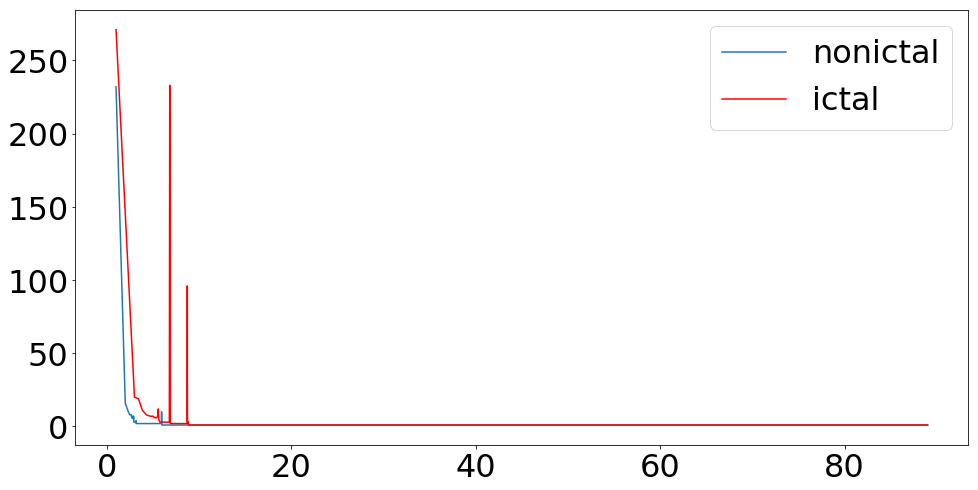

In [80]:
fig = plt.figure(figsize=(16,8))
plt.plot(sorted_negative_bs, sorted_negative_ns)
plt.plot(sorted_bs,sorted_ns,c='r')
plt.legend(["nonictal", "ictal"])
plt.savefig(os.path.join(project_dir, "meanshift_clusters_ictal_vs_nonictal.png"))

In [ ]:
nonictal_bandwidths_filename = os.path.join(project_dir, "nonictal_meanshift_bandwidths.dat")
np.savetxt(nonictal_bandwidths_filename, list(zip(sorted_negative_bs, sorted_negative_ns)))
np.loadtxt(nonictal_bandwidths_filename)

In [ ]:
ictal_bandwidths_filename = os.path.join(project_dir, "ictal_meanshift_bandwidths.dat")
np.savetxt(ictal_bandwidths_filename, list(zip(sorted_bs, sorted_ns)))
np.loadtxt(ictal_bandwidths_filename)